## Coding Assignment

1\. Fix and improve the pipeline code you submitted for the last assignment based on the feedback from the TAs. if something critical was pointed out in the feedback, you need to fix it.

In [41]:
%matplotlib inline

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier,
                              BaggingClassifier)
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (roc_curve,
                             precision_recall_curve, 
                             average_precision_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             auc, 
                             classification_report, 
                             confusion_matrix, 
                             f1_score)
from time import time
from inspect import signature
from pprint import pprint

* Import data

In [1]:
sns.set(style='whitegrid')
sns.set_color_codes('deep')

NameError: name 'sns' is not defined

In [11]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
credit = pd.read_csv('data/credit-data.csv')
credit.head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0


* Filling in missing values

In [13]:
# Number of missing values
credit.isnull().sum().sort_values(ascending = False)

MonthlyIncome                           29731
NumberOfDependents                       3924
NumberOfTime60-89DaysPastDueNotWorse        0
NumberRealEstateLoansOrLines                0
NumberOfTimes90DaysLate                     0
NumberOfOpenCreditLinesAndLoans             0
DebtRatio                                   0
NumberOfTime30-59DaysPastDueNotWorse        0
zipcode                                     0
age                                         0
RevolvingUtilizationOfUnsecuredLines        0
SeriousDlqin2yrs                            0
PersonID                                    0
dtype: int64

In [14]:
credit = credit.fillna(credit.mean(), inplace=True)
credit.isnull().sum().sort_values(ascending = False)

NumberOfDependents                      0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberRealEstateLoansOrLines            0
NumberOfTimes90DaysLate                 0
NumberOfOpenCreditLinesAndLoans         0
MonthlyIncome                           0
DebtRatio                               0
NumberOfTime30-59DaysPastDueNotWorse    0
zipcode                                 0
age                                     0
RevolvingUtilizationOfUnsecuredLines    0
SeriousDlqin2yrs                        0
PersonID                                0
dtype: int64

Because it is not very appropriate to fill in the missing values of `NumberOfDependents` with its average, we will aviod using this feature.

### Pipeline: `data_import()`
Summarize the procedures above into a function

In [15]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


def data_import(filepath, fill_in_missing=True):
    """
    Read in data and fill in missing values with mean if necessary.
    
    Args:
        filepath: str; data file path.
        fill_in_missing: bool; default to True; whether filling in missing
            values with mean.
    
    Return:
        data: df; a pandas dataframe of the imported data.
    """

    data = pd.read_csv(filepath)
    
    if fill_in_missing:
        data = data.fillna(data.mean(), inplace=True)
    
    return data

In [16]:
# Sanity check
test = data_import('data/credit-data.csv')
test.head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0


* Select features

In [17]:
from sklearn import cross_validation, metrics, preprocessing
from sklearn.feature_selection import SelectKBest, f_classif

In [18]:
features_all = list(credit.columns)
features_all.remove('SeriousDlqin2yrs')
features_all

['PersonID',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'zipcode',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [21]:
kbest = SelectKBest(f_classif, k=4)
features_new = kbest.fit_transform(credit[features_all], 
                                   credit.SeriousDlqin2yrs)

kbest_scores_sorted = pd.Series(kbest.scores_).sort_values(ascending=False)
kbest_scores_sorted

4     2403.692551
8     2088.125783
2     2023.993129
10    1585.147983
11     312.839515
7      132.148153
6       48.624383
5        8.669219
9        7.430531
3        3.906474
0        1.176628
1        0.486807
dtype: float64

In [22]:
for i in kbest_scores_sorted.index:
    print(features_all[i])

NumberOfTime30-59DaysPastDueNotWorse
NumberOfTimes90DaysLate
age
NumberOfTime60-89DaysPastDueNotWorse
NumberOfDependents
NumberOfOpenCreditLinesAndLoans
MonthlyIncome
DebtRatio
NumberRealEstateLoansOrLines
zipcode
PersonID
RevolvingUtilizationOfUnsecuredLines


In [23]:
plt.plot(range(len(kbest_scores_sorted)), kbest_scores_sorted, lw=2)
plt.xticks(np.arange(len(kbest_scores_sorted)))
plt.xlim(0, 11)
plt.title('Feature Scores', y=1.02)

Since a big gap lies between feature \#3 and \#4 (index starts with 0), we will use the first 4 features as training features in consideration of efficiency.

### Scaling

In [24]:
min_max_scaler = preprocessing.MinMaxScaler()
features_minmax = min_max_scaler.fit_transform(features_new)

In [25]:
labels = credit.SeriousDlqin2yrs

### Splitting training and testing set

In [26]:
# Random state
RNG = 1234

In [27]:
features_train, features_test, labels_train, labels_test = \
    cross_validation.train_test_split(features_minmax, labels,
                                      test_size=0.3, random_state=RNG)

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
# Sanity check
clf = KNeighborsClassifier()
clf.fit(features_train, labels_train)
print(classification_report(labels_test, clf.predict(features_test)))

             precision    recall  f1-score   support

          0       0.94      0.99      0.96     42020
          1       0.46      0.18      0.26      2980

avg / total       0.91      0.93      0.92     45000



### Pipeline: `data_preprocess()`

In [30]:
from sklearn import cross_validation, metrics, preprocessing
from sklearn.feature_selection import SelectKBest, f_classif
    

def data_preprocess(data, label_str, scale=True, RNG=1234, test_size=0.3,
                    **kwargs):
    """
    Preprocess the data with K best selecting, scaling, and train 
        test splitting.
        
    Args:
        data: df; the dataframe.
        label_str: str; the column name for labels.
        scale: bool, defaut to True; whether scale features with 
            minmax scaler.
        RNG: int, default to 1234; random state.
        test_size: float, default to 0.3; relative size of the testing set.
        kwargs: kwargs passed to SelectKBest().
        
    Returns:
        features_train, features_test, labels_train, labels_test
    """

    features_all = list(data.columns)
    features_all.remove(label_str)
    labels = data[label_str]
        
    kbest = SelectKBest(f_classif, **kwargs)
    features_new = kbest.fit_transform(data[features_all], labels)

    if scale:
        min_max_scaler = preprocessing.MinMaxScaler()
        features_new = min_max_scaler.fit_transform(features_new)
        
    return cross_validation.train_test_split(features_new, labels,
                              test_size=test_size, random_state=RNG)

In [31]:
features_train, features_test, labels_train, labels_test = \
    data_preprocess(test, 'SeriousDlqin2yrs', k=4)

2\. Add more classifiers to the pipeline. I’d recommend at least having Logistic Regression, K-Nearest Neighbor, Decision Trees, SVM, Random Forests, Boosting, and Bagging. The code should have a parameter for running one or more of these classifiers and your analysis should run all of them.

3\. Experiment with different parameters for these classifiers (different values of k for example, as well as parameters that other classifiers have). You should look at the sklearn documentation to see what parameter each classifier can take and what the default values sklearn selects.

### Adding more classifiers

In [32]:
def classifier_exp(clf, params, kwargs={'random_state': 1234,
                                        'n_jobs': -1}):
    """
    Experiment with different parameters for the classifier; report 
        the scores and the best parameter set.
    
    Args:
        clf: classifier object; the testing classifier algorithm
        params: dict; experimental parameter sets
        kwargs: dict, default to {'random_state': 1234, 'n_jobs': -1}; 
            additional keyword arguments passed to the classifier 
            function call
    """
    
    svr = clf(**kwargs)
    clf = GridSearchCV(svr, params)
    clf.fit(features_train, labels_train)

    print(classification_report(labels_test, clf.predict(features_test)))
    print('\nBest params: {}'.format(clf.best_params_))

#### Logistic regression

In [33]:
params_lr = {'C':[1.0, 3.0],    # Default to 1.0
             'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag')}
                      # Default to 'liblinear'

classifier_exp(LogisticRegression, params_lr)

             precision    recall  f1-score   support

          0       0.93      1.00      0.97     42020
          1       0.62      0.02      0.03      2980

avg / total       0.91      0.93      0.90     45000


Best params: {'C': 3.0, 'solver': 'newton-cg'}


In [34]:
clf = LogisticRegression(C=3.0, solver='newton-cg', random_state=1234,
                         n_jobs=-1)

labels_score = clf.fit(features_train, labels_train).decision_function(
                                                          features_test)

precision, recall, thresholds = precision_recall_curve(labels_test,
                                                       labels_score)

average_precision = average_precision_score(labels_test, labels_score)

In [35]:
labels_pred = clf.predict(features_test)

In [36]:
accuracy_score(labels_test, labels_pred)

0.93420000000000003

In [37]:
f1_score(labels_test, labels_pred)

0.032669062397909183

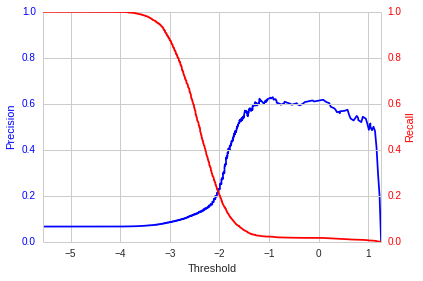

In [42]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], 'b')
ax.set_xlabel('Threshold')
ax.set_ylabel('Precision', color='b')
ax.tick_params('y', colors='b')
plt.ylim(0.0, 1.0)

ax2 = ax.twinx()
ax2.plot(thresholds, recall[:-1], 'r')
ax2.set_ylabel('Recall', color='r')
ax2.tick_params('y', colors='r')
plt.ylim(0.0, 1.0)
plt.xlim(thresholds.min(), thresholds.max())
fig.tight_layout()

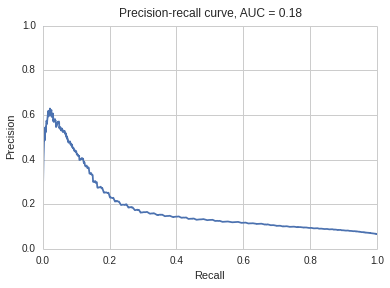

In [43]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.title('Precision-recall curve, AUC = {:.2f}'.format(average_precision),
          y=1.02)
plt.legend(loc='best')

ROC

In [44]:
fpr, tpr, thresholds = roc_curve(labels_test, labels_score)
roc_auc = auc(fpr, tpr)

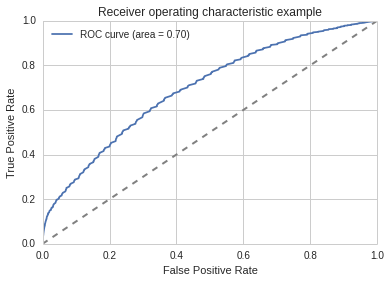

In [45]:
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], c='grey', lw=2, ls='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='best')

#### K-NN

In [46]:
params_knn = {'n_neighbors': [3, 5],    # Default to 5
             'leaf_size': [5, 10, 30]}    # Default to 30

classifier_exp(KNeighborsClassifier, params_knn, kwargs={})

             precision    recall  f1-score   support

          0       0.94      0.99      0.96     42020
          1       0.46      0.18      0.26      2980

avg / total       0.91      0.93      0.92     45000


Best params: {'leaf_size': 30, 'n_neighbors': 5}


#### Decision Tree and Random Forest

In [68]:
arg_rs = {'random_state': 1234}    # Random state keyword argument

In [13]:
params_dt = {'criterion': ('gini', 'entropy'),    # Default to 'gini'
             'max_features': (None, 'sqrt', 'log2'),    # Default to None
             'min_samples_split': [2, 10]}    # Default to 2

classifier_exp(DecisionTreeClassifier, params_dt, 
               kwargs=arg_rs)

             precision    recall  f1-score   support

          0       0.94      0.99      0.97     42020
          1       0.49      0.16      0.24      2980

avg / total       0.91      0.93      0.92     45000


Best params: {'criterion': 'gini', 'min_samples_split': 10, 'max_features': 'sqrt'}


In [16]:
params_rf = {'n_estimators': [5, 10, 100],    # Default to 10
             'criterion': ('gini', 'entropy'),    # Default to 'gini'
             'min_samples_split': [2, 10]}    # Default to 2

classifier_exp(RandomForestClassifier, params_rf)

             precision    recall  f1-score   support

          0       0.94      0.99      0.97     42020
          1       0.50      0.18      0.27      2980

avg / total       0.92      0.93      0.92     45000


Best params: {'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 100}


#### SVM

In [74]:
params_svm = {'C': [1, 5]}    # Default to 1.0

classifier_exp(SVC, params_svm, kwargs=arg_rs)

             precision    recall  f1-score   support

          0       0.93      1.00      0.97     42020
          1       0.79      0.01      0.01      2980

avg / total       0.92      0.93      0.90     45000


Best params: {'C': 5}


#### Boosting

In [70]:
params_ab = {'n_estimators': [10, 50],    # Default to 50
             'algorithm': ('SAMME', 'SAMME.R')}    # Default to SAMME.R

classifier_exp(AdaBoostClassifier, params_ab, kwargs=arg_rs)

             precision    recall  f1-score   support

          0       0.94      0.99      0.97     42020
          1       0.58      0.18      0.28      2980

avg / total       0.92      0.94      0.92     45000


Best params: {'algorithm': 'SAMME.R', 'n_estimators': 50}


#### Bagging

In [73]:
params_bg = {'n_estimators': [5, 10]}    # Default to 10

classifier_exp(BaggingClassifier, params_bg)

             precision    recall  f1-score   support

          0       0.94      0.99      0.96     42020
          1       0.48      0.16      0.24      2980

avg / total       0.91      0.93      0.92     45000


Best params: {'n_estimators': 10}


### Pipeline: `classifier_fit()`

In [131]:
# Turn True to False to disable that method in `classifier_fit()`

clf_switch =  {'LR': [True, LogisticRegression, 
                     {'C': 3.0, 'solver': 'newton-cg'}],
               'DT': [True, DecisionTreeClassifier,
                     {'criterion': 'gini', 'min_samples_split': 10, 
                      'max_features': 'sqrt'}],
               'K-NN': [True, KNeighborsClassifier,
                     {'leaf_size': 30, 'n_neighbors': 5}],
               'SVM': [True, SVC, {'C': 5}],
               'AB': [True, AdaBoostClassifier, 
                     {'algorithm': 'SAMME.R', 'n_estimators': 50}],
               'RF': [True, RandomForestClassifier,
                     {'criterion': 'gini', 'min_samples_split': 10, 
                      'max_features': 'sqrt'}],
               'BG': [True, BaggingClassifier,
                     {'n_estimators': 10}]}

In [132]:
def classifier_fit(train_test_ls, clf_switch=clf_switch, RNG=1234):
    """
    Fit the algorithm and record key statistics.
    
    Args:
        train_test_ls: ls; list of features_train, features_test, 
            labels_train, labels_test
        clf_switch: dict; Customized data structure of 
            {'clf_name': [bool, estimator, kwargs_dict]}
        RNG: int, default to 1234; random state
    
    Return:
        rv: dict; objects and statistics about the classifiers, 
                for example:
                
            {'LR': {
                'estimator': LogisticRegression,
                'kwargs': kwargs,
                'clf': clf.fit,
                'labels_score': clf.decision_function,
                'labels_pred': clf.predict,
                'time': {
                    'training': training_time,
                    'predicting': predicting_time},
                'evaluation': {
                    'precision': prec,
                    'recall': recall,
                    'precision_recall_curve': {
                         'precision': precision,
                         'recall': recall,
                         'thresholds': thresholds,
                         'avg_precision': average_precision},
                    'accuracy_score': accuracy_score,
                    'f1_score': f1_score,
                    'ROC': {
                        'fpr': fpr,
                        'tpr': tpr,
                        'thresholds': thresholds
                        'roc_auc': auc}}
                    },
              'KNN': {...},
              'SVM': {...},
             }
    """
    
    rv = {}
    
    for clf_name, switch in clf_switch.items():
        if switch[0]: 
            est = switch[1]    # Estimator (method)
            kwargs = switch[2]
            
            rv[clf_name] = {}
            rv[clf_name]['estimator'] = est
            
            sig_params = signature(est).parameters
            if 'n_jobs' in sig_params:
                kwargs['n_jobs'] = -1
                
            if 'random_state' in sig_params:
                kwargs['random_state'] = RNG
                
            rv[clf_name]['kwargs'] = kwargs
                
            clf = est(**kwargs)
            
            # Training
            t0 = time()
            clf.fit(features_train, labels_train)
            rv[clf_name]['time'] = {}
            rv[clf_name]['time']['training'] = round(time() - t0, 3)
            
            rv[clf_name]['clf'] = clf
            
            # Predict
            t0 = time()
            labels_pred = clf.predict(features_test)
            rv[clf_name]['time']['predicting'] = round(time() - t0, 3)
            
            rv[clf_name]['evaluation'] = {}
            
            try:
                labels_score = clf.decision_function(features_test)
                rv[clf_name]['labels_score'] = labels_score
                
                precision, recall, thresholds_prc = \
                    precision_recall_curve(labels_test, labels_score)
                    
                rv[clf_name]['evaluation']['precision_recall_curve'] = {}
            
                rv[clf_name]['evaluation']['precision_recall_curve']\
                    ['precision'] = precision
                rv[clf_name]['evaluation']['precision_recall_curve']\
                    ['recall'] = recall
                rv[clf_name]['evaluation']['precision_recall_curve']\
                    ['thresholds'] = thresholds_prc

                avg_precision = average_precision_score(labels_test, 
                                                        labels_score)
                rv[clf_name]['evaluation']['precision_recall_curve']\
                    ['avg_precision'] = avg_precision
                    
                fpr, tpr, thresholds_roc = roc_curve(labels_test, 
                                                     labels_score)
                roc_auc = auc(fpr, tpr)
                
                rv[clf_name]['evaluation']['ROC'] = {}
                rv[clf_name]['evaluation']['ROC']['fpr'] = fpr
                rv[clf_name]['evaluation']['ROC']['tpr'] = tpr
                rv[clf_name]['evaluation']['ROC']['thresholds'] = \
                                                        thresholds_roc
                rv[clf_name]['evaluation']['ROC']['roc_auc'] = roc_auc
                    
            except AttributeError:
                rv[clf_name]['labels_score'] = None

            precision = precision_score(labels_test, labels_pred)
            recall = recall_score(labels_test, labels_pred)

            rv[clf_name]['evaluation']['precision'] = precision
            rv[clf_name]['evaluation']['recall'] = recall

            accu_score = accuracy_score(labels_test, labels_pred)
            rv[clf_name]['evaluation']['accuracy_score'] = accu_score
            
            f1 = f1_score(labels_test, labels_pred)
            rv[clf_name]['evaluation']['f1_score'] = f1

    return rv    

In [135]:
clf_dict = classifier_fit([features_train, features_test, labels_train, 
                           labels_test], clf_switch=clf_switch)

### Pipeline: `classifier_evaluate()`

In [167]:
def classifier_compare(clf_dict):
    """
    Print out and compare key statistics from clf_dict
    """
    
    comparison_tables = []
    
    print('Accuracy scores:')
    ls = []
    for clf_name, clf_subdict in clf_dict.items():
        accu_score = round(clf_subdict['evaluation']['accuracy_score'], 3)      
        ls.append({'accuracy': accu_score, 'clf': clf_name})        
    df = pd.DataFrame(ls)
    comparison_tables.append(df)
    
    fig, ax = plt.subplots()
    sns.barplot(x='clf', y='accuracy', data=df, 
                order=df.sort_values('accuracy', ascending=False).clf)
    plt.ylabel('Accuracy score')
    plt.xlabel('Classifier')
    plt.title('Accuracy')

    
    print('\nF1 scores:')
    ls = []
    for clf_name, clf_subdict in clf_dict.items():
        f1 = round(clf_subdict['evaluation']['f1_score'], 3)
        ls.append({'f1': f1, 'clf': clf_name})
    df = pd.DataFrame(ls)
    comparison_tables.append(df)
    
    fig, ax = plt.subplots()
    sns.barplot(x='clf', y='f1', data=df, 
                order=df.sort_values('f1', ascending=False).clf)
    plt.ylabel('F1 score')
    plt.xlabel('Classifier')
    plt.title('F1 score')
    
    
    print('\nPrecision scores:')        
    ls = []
    for clf_name, clf_subdict in clf_dict.items():
        precision = round(clf_subdict['evaluation']['precision'], 3)
        print(clf_name, precision)
        ls.append({'precision': precision, 'clf': clf_name})
    df = pd.DataFrame(ls)
    comparison_tables.append(df)
    
    fig, ax = plt.subplots()
    sns.barplot(x='clf', y='precision', data=df, 
                order=df.sort_values('precision', ascending=False).clf)
    plt.ylabel('Precision score')
    plt.xlabel('Classifier')
    plt.title('Precision score')
    
        
    print('\nRecall scores:')
    ls = []
    for clf_name, clf_subdict in clf_dict.items():
        recall = round(clf_subdict['evaluation']['recall'], 3)
        print(clf_name, recall)
        ls.append({'recall': recall, 'clf': clf_name})
    df = pd.DataFrame(ls)
    comparison_tables.append(df)
    
    fig, ax = plt.subplots()
    sns.barplot(x='clf', y='recall', data=df, 
                order=df.sort_values('recall', ascending=False).clf)
    plt.ylabel('Recall score')
    plt.xlabel('Classifier')
    plt.title('Recall score')
    
    
    print('\nTraining + predicting time (seconds): ')
    ls = []
    for clf_name, clf_subdict in clf_dict.items():
        time = round(clf_subdict['time']['training'] + 
                              clf_subdict['time']['predicting'], 3)
        print(clf_name, time)
        ls.append({'time': time, 'clf': clf_name})
    df = pd.DataFrame(ls)
    comparison_tables.append(df)
    
    fig, ax = plt.subplots()
    sns.barplot(x='clf', y='time', data=df, 
                order=df.sort_values('time', ascending=False).clf)
    plt.ylabel('Time')
    plt.xlabel('Classifier')
    plt.title('Running time')
        
    print('\nPrecision recall curves:')
    for clf_name, clf_subdict in clf_dict.items():
        
        if clf_subdict['labels_score'] is not None:

            precision = clf_subdict['evaluation']['precision_recall_curve']\
                ['precision']
            recall = clf_subdict['evaluation']['precision_recall_curve']\
                ['recall']
            thresholds_prc = clf_subdict['evaluation']\
                ['precision_recall_curve']['thresholds']

            fig, ax = plt.subplots()
            ax.plot(thresholds_prc, precision[:-1], 'b')
            ax.set_xlabel('Threshold')
            ax.set_ylabel('Precision', color='b')
            ax.tick_params('y', colors='b')
            plt.ylim(0.0, 1.0)

            ax2 = ax.twinx()
            ax2.plot(thresholds_prc, recall[:-1], 'r')
            ax2.set_ylabel('Recall', color='r')
            ax2.tick_params('y', colors='r')
            plt.ylim(0.0, 1.0)
            plt.xlim(thresholds_prc.min(), thresholds_prc.max())
            fig.tight_layout()
            plt.title('Precision and recall at different levels: {}'\
                       .format(clf_name), y=1.02)

    
    
    fig, ax = plt.subplots()
    for clf_name, clf_subdict in clf_dict.items():
        if clf_dict[clf_name]['labels_score'] is not None:
            precision = clf_subdict['evaluation']['precision_recall_curve']\
                ['precision']
            recall = clf_subdict['evaluation']['precision_recall_curve']\
                ['recall']
            avg_precision = clf_subdict['evaluation']\
                ['precision_recall_curve']['avg_precision']

            plt.plot(recall, precision, 
                     label='{}, AUC: {}'.format(clf_name, 
                                            round(avg_precision, 3)))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.title('Precision-recall curves', y=1.02)
    plt.legend(loc='best')
    
    
    print('ROC curves:')
    fig, ax = plt.subplots()
    for clf_name, clf_subdict in clf_dict.items():
        if clf_dict[clf_name]['labels_score'] is not None:
            fpr = clf_subdict['evaluation']['ROC']['fpr']
            tpr = clf_subdict['evaluation']['ROC']['tpr']
            thresholds_roc= clf_subdict['evaluation']['ROC']['thresholds']                                                    
            roc_auc = clf_subdict['evaluation']['ROC']['roc_auc']
            
            plt.plot(fpr, tpr, label='{}, AUC: {:.3f}'\
                     .format(clf_name, roc_auc))
            
    plt.plot([0, 1], [0, 1], c='grey', lw=2, ls='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curves')
    plt.legend(loc='best')
    
    return comparison_tables

Accuracy scores:

F1 scores:

Precision scores:
RF 0.502
DT 0.489
SVM 0.786
BG 0.478
K-NN 0.464
AB 0.578
LR 0.617

Recall scores:
RF 0.178
DT 0.163
SVM 0.007
BG 0.16
K-NN 0.181
AB 0.182
LR 0.017

Training + predicting time (seconds): 
RF 0.226
DT 0.037
SVM 112.431
BG 0.57
K-NN 7.029
AB 1.143
LR 0.534

Precision recall curves:
ROC curves:


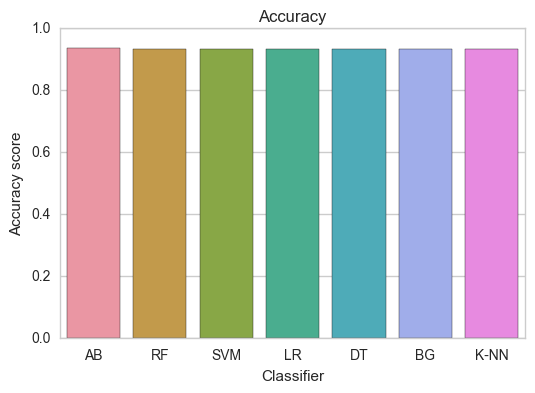

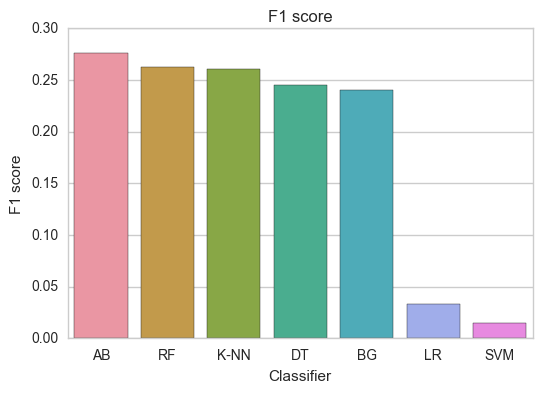

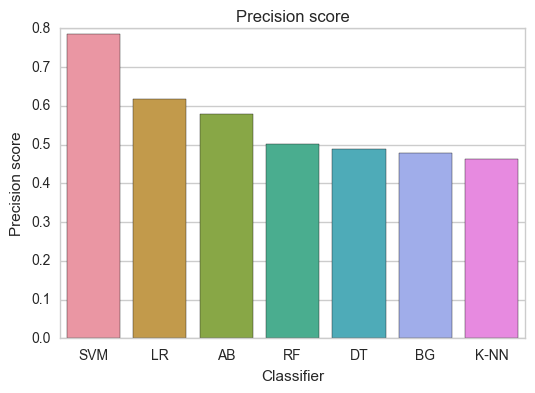

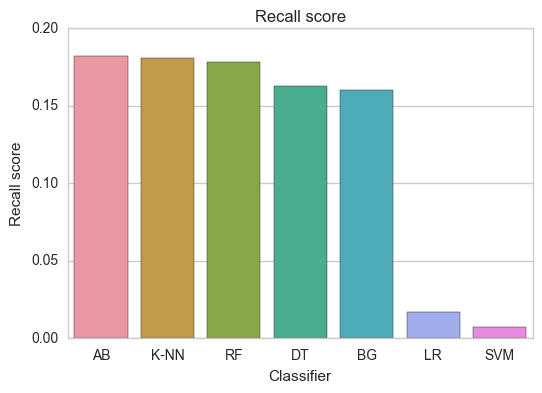

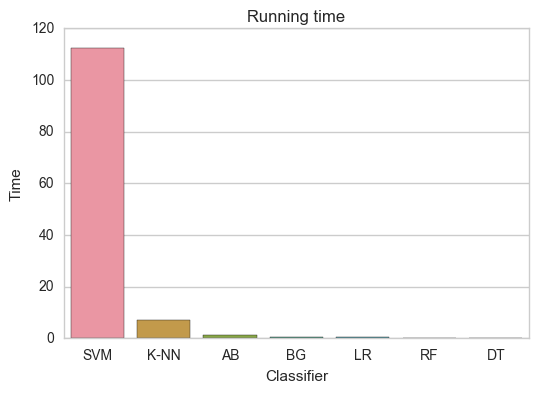

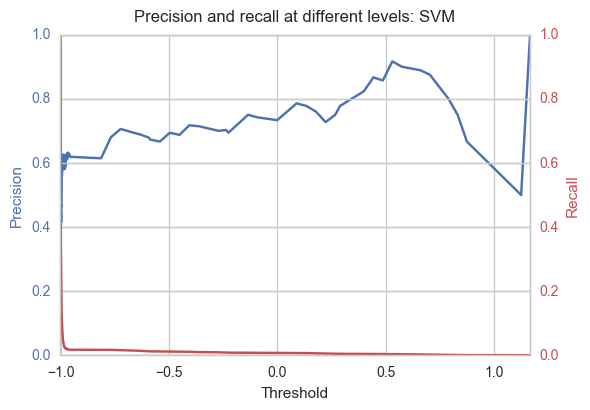

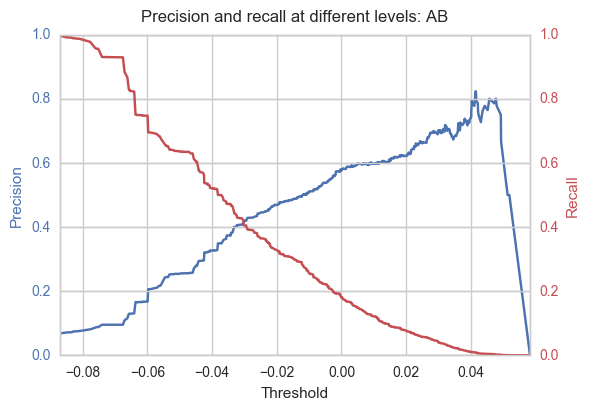

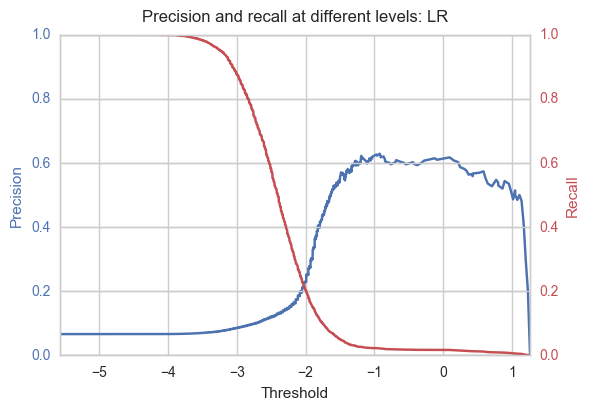

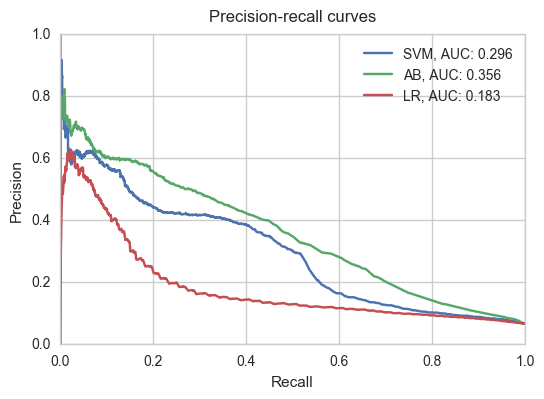

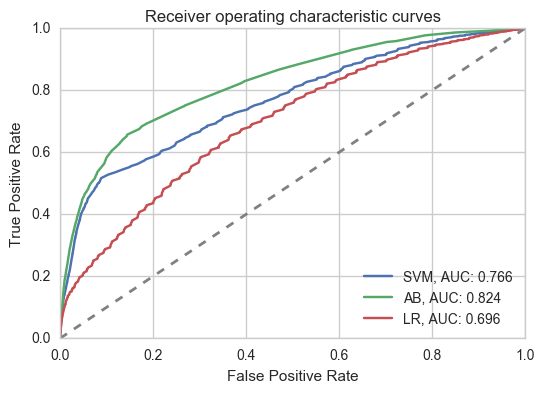

In [177]:
comparison_tables = classifier_compare(clf_dict)

In [174]:
from functools import reduce

def merge(df1, df2):
    return pd.merge(df1, df2, on='clf')

In [176]:
reduce(merge, comparison_tables)

,accuracy,clf,f1,precision,recall,time
0,0.934,RF,0.263,0.502,0.178,0.226
1,0.933,DT,0.245,0.489,0.163,0.037
2,0.934,SVM,0.015,0.786,0.007,112.431
3,0.933,BG,0.240,0.478,0.160,0.570
4,0.932,K-NN,0.261,0.464,0.181,7.029
5,0.937,AB,0.276,0.578,0.182,1.143
6,0.934,LR,0.033,0.617,0.017,0.534


## Report

For accuracy, all the classifiers perform the same and yield satisfying results around 0.933. AdaBoost is slightly better than the others.

For precision, SVM yields the best precision score. However, it yields the worst score on recall. From the precision-recall-thresholds chart we can also see that its performance is very unstable.

F1 score is a generalization of both precision and recall. It indicates, in consideration of the tradeoff between precision and recall, AdaBoost is the most well balanced, followed by Random Forest.

With respect to the running time, SVM is the longest, which is 10 times slower than the second longest, K-Nearest Neighbor. The rest of the algorithms run pretty fast.

Given AdaBoost also have the largest AUC from ROC and precision-recall curve, in conclusion, I would recommend AdaBoost with arguments `{'algorithm': 'SAMME.R', 'n_estimators': 50}` for this dataset.